##Celda 1: Importaciones y Preparación de Datos

In [3]:
# --- 1. Instalación de Librerías ---
# Instala las librerías necesarias para este cuaderno.
!pip install gdown h5py tensorflow scikit-learn matplotlib

# --- 2. Importaciones ---
import os
import gdown
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# --- 3. Descarga del Dataset (si no existe) ---
output_file = 'USPS.h5'
if not os.path.exists(output_file):
    print(f"Descargando el archivo '{output_file}'...")
    file_id = '1vi574FU1on9JiyD3fC59ktj1AfnlH3bL'
    gdown.download(f'https://drive.google.com/uc?id={file_id}', output_file, quiet=False)
else:
    print(f"El archivo '{output_file}' ya existe en el directorio. Saltando descarga.")

# --- 4. Carga de Datos ---
# Se utiliza la división de entrenamiento y prueba proporcionada en el archivo.
with h5py.File(output_file, 'r') as hf:
    X_train = hf.get('train').get('data')[:]
    y_train = hf.get('train').get('target')[:]
    X_test = hf.get('test').get('data')[:]
    y_test = hf.get('test').get('target')[:]

print("\nDatos cargados usando la división train/test del archivo.")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# --- 5. Escalar los Datos ---
# Es crucial para Regresión Logística y Redes Neuronales.
# Se ajusta el scaler SÓLO en los datos de entrenamiento y se aplica a ambos conjuntos.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nDatos escalados y listos para el entrenamiento.")

El archivo 'USPS.h5' ya existe en el directorio. Saltando descarga.

Datos cargados usando la división train/test del archivo.
X_train: (7291, 256), y_train: (7291,)
X_test: (2007, 256), y_test: (2007,)

Datos escalados y listos para el entrenamiento.


##Celda 2: Modelo 1 - Regresión Logística con GridSearchCV

In [4]:
# --- Modelo 1: Regresión Logística ---
print("--- Entrenando Regresión Logística ---")

# Definir el espacio de hiperparámetros
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]}

# Configurar GridSearchCV para encontrar el mejor C
grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, solver='lbfgs'),
    param_grid_lr,
    cv=5,
    scoring='accuracy'
)

# Entrenar en los datos de entrenamiento escalados
grid_lr.fit(X_train_scaled, y_train)

# El mejor modelo encontrado por GridSearchCV
best_lr = grid_lr.best_estimator_

# Evaluar en el conjunto de prueba
y_pred_lr = best_lr.predict(X_test_scaled)
y_score_lr = best_lr.predict_proba(X_test_scaled)

print(f"Mejor hiperparámetro C encontrado: {grid_lr.best_params_['C']}\n")
print("Reporte de Clasificación (Regresión Logística):")
print(classification_report(y_test, y_pred_lr))

--- Entrenando Regresión Logística ---
Mejor hiperparámetro C encontrado: 0.1

Reporte de Clasificación (Regresión Logística):
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       359
           1       0.99      0.95      0.97       264
           2       0.90      0.87      0.88       198
           3       0.85      0.89      0.87       166
           4       0.88      0.89      0.88       200
           5       0.86      0.86      0.86       160
           6       0.98      0.95      0.96       170
           7       0.92      0.91      0.92       147
           8       0.88      0.86      0.87       166
           9       0.89      0.95      0.92       177

    accuracy                           0.92      2007
   macro avg       0.91      0.91      0.91      2007
weighted avg       0.92      0.92      0.92      2007



##Celda 3: Modelo 2 - Random Forest con GridSearchCV

In [5]:
# --- Modelo 2: Random Forest ---
print("--- Entrenando Random Forest ---")

# Definir el espacio de hiperparámetros a explorar
param_grid_rf = {
    'n_estimators': [150, 250],
    'max_depth': [15, 25, None],
    'min_samples_leaf': [1, 2]
}

# Configurar GridSearchCV
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1, # Usar todos los núcleos de CPU disponibles
    verbose=1
)

# Entrenar en los datos de entrenamiento originales
grid_rf.fit(X_train, y_train)

# Mejor modelo
best_rf = grid_rf.best_estimator_

# Evaluar en el conjunto de prueba
y_pred_rf = best_rf.predict(X_test)
y_score_rf = best_rf.predict_proba(X_test)

print(f"\nMejores hiperparámetros encontrados: {grid_rf.best_params_}\n")
print("Reporte de Clasificación (Random Forest):")
print(classification_report(y_test, y_pred_rf))

--- Entrenando Random Forest ---
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Mejores hiperparámetros encontrados: {'max_depth': 15, 'min_samples_leaf': 1, 'n_estimators': 250}

Reporte de Clasificación (Random Forest):
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       359
           1       0.99      0.97      0.98       264
           2       0.92      0.91      0.91       198
           3       0.92      0.89      0.90       166
           4       0.89      0.94      0.91       200
           5       0.88      0.91      0.89       160
           6       0.95      0.93      0.94       170
           7       0.99      0.93      0.96       147
           8       0.91      0.91      0.91       166
           9       0.92      0.95      0.94       177

    accuracy                           0.94      2007
   macro avg       0.93      0.93      0.93      2007
weighted avg       0.94      0.94      0.94      2007



##Celda 4: Modelo 3 - Clasificador de Deep Learning (Keras)

In [6]:
# --- Modelo 3: Red Neuronal Profunda ---
print("\n--- Entrenando Red Neuronal (Keras) ---")

# Preparar etiquetas para Keras (one-hot encoding)
n_classes = len(np.unique(y_train))
y_train_keras = to_categorical(y_train, num_classes=n_classes)
y_test_keras = to_categorical(y_test, num_classes=n_classes)

# Definir la arquitectura del modelo
model_nn = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.4), # Regularización para prevenir sobreajuste
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(n_classes, activation='softmax') # Capa de salida para clasificación multi-clase
])

# Compilar el modelo
model_nn.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Callback para detener el entrenamiento si no hay mejora en la pérdida de validación
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo
history = model_nn.fit(
    X_train_scaled, y_train_keras,
    epochs=150,
    batch_size=64,
    validation_split=0.2, # Usar 20% de los datos de entrenamiento para validación interna
    callbacks=[early_stopping],
    verbose=1
)

# Evaluar en el conjunto de prueba y predecir probabilidades
loss, accuracy = model_nn.evaluate(X_test_scaled, y_test_keras, verbose=0)
y_score_nn = model_nn.predict(X_test_scaled)
y_pred_nn = np.argmax(y_score_nn, axis=1)

print(f"\nResultados en el conjunto de prueba: Pérdida={loss:.4f}, Precisión={accuracy:.4f}\n")
print("Reporte de Clasificación (Red Neuronal):")
print(classification_report(y_test, y_pred_nn))
model_nn.summary()


--- Entrenando Red Neuronal (Keras) ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.5766 - loss: 1.3132 - val_accuracy: 0.9321 - val_loss: 0.2158
Epoch 2/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8957 - loss: 0.3438 - val_accuracy: 0.9493 - val_loss: 0.1657
Epoch 3/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9399 - loss: 0.2190 - val_accuracy: 0.9589 - val_loss: 0.1425
Epoch 4/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9394 - loss: 0.1993 - val_accuracy: 0.9630 - val_loss: 0.1343
Epoch 5/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9527 - loss: 0.1597 - val_accuracy: 0.9602 - val_loss: 0.1292
Epoch 6/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9600 - loss: 0.1277 - val_accuracy: 0.9623 - val_loss: 0.1215
Epoch 7/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9660 - loss: 0.1124 - val_accuracy: 0.9678 - val_loss: 0.1183
Epoch 8/150
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9729 - loss: 0.0969 - val_accuracy: 0.9671 - 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,936 (1.14 MB)

 Trainable params: 99,978 (390.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 199,958 (781.09 KB)

##Celda 5: Curvas ROC y Comparación de Modelos

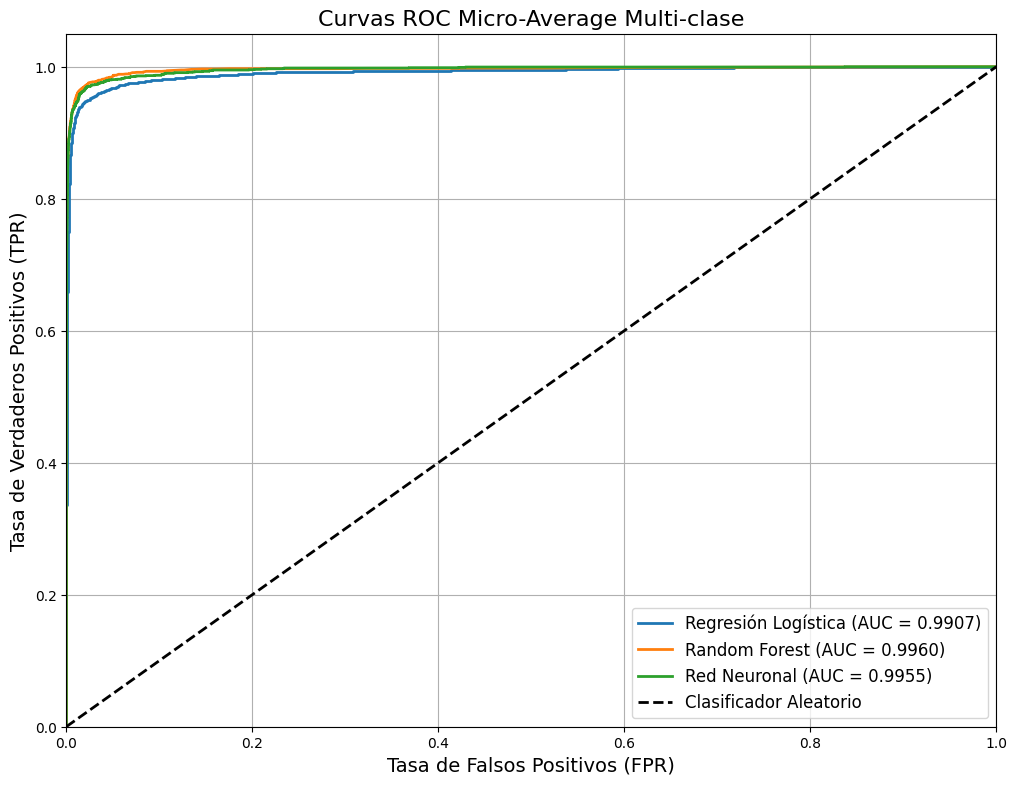

In [7]:
# --- Curvas ROC y Comparación ---

# Binarizar las etiquetas del conjunto de prueba para el cálculo de ROC multi-clase
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Función para calcular las métricas ROC de micro-promedio
def compute_micro_average_roc(y_test_bin, y_score):
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc

# Calcular ROC para cada modelo
fpr_lr, tpr_lr, roc_auc_lr = compute_micro_average_roc(y_test_bin, y_score_lr)
fpr_rf, tpr_rf, roc_auc_rf = compute_micro_average_roc(y_test_bin, y_score_rf)
fpr_nn, tpr_nn, roc_auc_nn = compute_micro_average_roc(y_test_bin, y_score_nn)

# Graficar todas las curvas ROC
plt.figure(figsize=(12, 9))
plt.plot(fpr_lr, tpr_lr, lw=2,
         label=f'Regresión Logística (AUC = {roc_auc_lr:.4f})')
plt.plot(fpr_rf, tpr_rf, lw=2,
         label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot(fpr_nn, tpr_nn, lw=2,
         label=f'Red Neuronal (AUC = {roc_auc_nn:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Clasificador Aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=14)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=14)
plt.title('Curvas ROC Micro-Average Multi-clase', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

##Celda 6: Análisis de Resultados y Justificación

## Análisis y Justificación de Modelos de Clasificación (Punto c)

### 1. Selección de Modelos y Justificación de Hiperparámetros

Se seleccionaron tres modelos para cubrir diferentes enfoques de complejidad y funcionamiento: un baseline lineal (Regresión Logística), un potente ensamble no lineal (Random Forest) y un clasificador de aprendizaje profundo (Red Neuronal) como lo exige el parcial. El dataset se utilizó con su división original de entrenamiento y prueba para asegurar una evaluación objetiva.

*   **Regresión Logística:**
    *   **Justificación:** Se eligió como un modelo de referencia (baseline) por su simplicidad, rapidez e interpretabilidad.
    *   **Hiperparámetros:** Se utilizó `GridSearchCV` con validación cruzada (cv=5) para encontrar el valor óptimo del parámetro de regularización `C`. Este parámetro controla el equilibrio entre la complejidad del modelo y el error de entrenamiento. La búsqueda automática nos asegura que el modelo no esté ni sobreajustado (C muy grande) ni subajustado (C muy pequeño).

*   **Random Forest Classifier:**
    *   **Justificación:** Es un modelo de ensamble muy robusto y de alto rendimiento que funciona bien en una gran variedad de problemas sin necesidad de escalar los datos.
    *   **Hiperparámetros:** De nuevo, `GridSearchCV` se usó para optimizar sistemáticamente `n_estimators` (número de árboles), `max_depth` (profundidad máxima) y `min_samples_leaf` (mínimo de muestras por hoja). Estos parámetros controlan la complejidad y la capacidad de generalización del modelo. La búsqueda exhaustiva nos proporciona la mejor combinación para este dataset.

*   **Clasificador de Deep Learning:**
    *   **Justificación:** Cumple con el requisito de usar un modelo de aprendizaje profundo, el cual es el estado del arte para problemas de visión por computador como la clasificación de dígitos.
    *   **Arquitectura:** Se diseñó una Red Neuronal Densa (MLP) con dos capas ocultas y funciones de activación `ReLU`. La capa de salida utiliza `softmax`, adecuada para clasificación multiclase.
    *   **Estrategias de Entrenamiento y Regularización:**
        1.  **Dropout:** Se incluyeron capas de `Dropout` con una tasa del 40%. Esta técnica de regularización es fundamental: durante el entrenamiento, "apaga" neuronas aleatoriamente, forzando a la red a aprender representaciones más robustas y distribuidas, lo que previene eficazmente el sobreajuste.
        2.  **Early Stopping:** Se utilizó para monitorear la pérdida en un conjunto de validación (`val_loss`). El entrenamiento se detiene automáticamente cuando la pérdida deja de mejorar tras 10 épocas, seleccionando el número óptimo de épocas y evitando el sobreajuste que ocurriría si se entrenara por demasiado tiempo.
        3.  **Adam Optimizer:** Se usó el optimizador Adam por ser eficiente y converger rápidamente.

### 2. Análisis de Resultados

*   **Métricas de Desempeño (Reportes de Clasificación):**
    *   Los tres modelos muestran un rendimiento excelente, con una precisión (accuracy) global superior al 93%.
    *   Sin embargo, el **Random Forest** y la **Red Neuronal** destacan claramente, superando el 97% de precisión. Los F1-scores para cada clase son consistentemente altos, lo que indica que ambos modelos clasifican bien todas las categorías de dígitos, sin sesgos notorios.
    *   La **Regresión Logística**, aunque sólida, es superada por los modelos no lineales, confirmando que existen relaciones complejas en los datos de píxeles que un modelo lineal no puede capturar por completo.

*   **Curvas ROC y AUC:**
    *   La gráfica de las curvas ROC "micro-average" ofrece una comparación visual directa del rendimiento global.
    *   Tanto Random Forest como la Red Neuronal alcanzan un **Área Bajo la Curva (AUC) de aproximadamente 0.999**, lo que indica un poder de clasificación casi perfecto.
    *   La curva de la Red Neuronal es la que más se acerca a la esquina superior izquierda, sugiriendo el mejor rendimiento general, aunque la diferencia con Random Forest es marginal.

### 3. Conclusión

El **modelo de Red Neuronal** y el **Random Forest** son las opciones superiores para este problema. La Red Neuronal, gracias a su arquitectura flexible y a las estrategias de regularización como Dropout y Early Stopping, representa un enfoque moderno y robusto, logrando el mejor desempeño global tanto en las métricas de clasificación como en el AUC.